# Modified GANomaly: Semi-Supervised Anomaly Detection via Adversarial Training (Method 2 - Modified GANomaly)

This notebook is based on the original GANomaly architecture proposed by Akcay et al, in 2018 (https://arxiv.org/abs/1805.06725). The model employs DCGAN architecutre (https://arxiv.org/abs/1511.06434) to create a new anomaly detection model using encoder-decoder-encoder sub-networks that generates high-dimensional image space. The model is trained solely on normal data (in our case undamaged car images), and it attemps to map the input image to a representative latent space, which is then used to reconstruct the generated output image. To map the generated image back to its latent representation, additional encoder network is used. The distance between the input image and the generated image, as well as their latent representations, are minimised during training.

<img src="../GANomaly.png" width="800" height="400">
- <i>Figure A. GANomaly model architechture with Encoder Decoder and Encoder network and the discriminator. </i>
    

The original architecture was built using a PyTorch library which is publicly available in a GitHub repository (https://github.com/samet-akcay/ganomaly). To gain a deeper familiarity with the model and more leeway for customization, we programmed the model architecture from scratch using TensorFlow and Keras libraries.

This notebook is the modified version of the Method 1 (original GANomaly method). Modifications are: 
- latent dimension 512
- kernel size 5x5
- soft and noisy labels
- adversarial loss: g_adv = (l2_loss(feat_real, feat_fake) + bce_loss(tf.ones_like(pred_fake), pred_fake)) * opt.w_adv
- adding noise to the discriminator
- Two Time-scale Update Rule (TTUR)

In [1]:
import py3nvml
import tensorflow as tf
import tensorflow_addons as tfa
py3nvml.grab_gpus(1, gpu_select=[0, 1, 2, 3], gpu_fraction=0.99)
physical_devices = tf.config.list_physical_devices("GPU")

In [2]:
from platform import python_version
print(python_version())
print(tf. __version__) 

3.8.10
2.8.0


## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import random
import math
import os.path
from os import path
import time
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython import display
from scipy.ndimage import gaussian_filter1d

## Options

In [4]:
class Option:
    def __init__(self):
        self.seed = 123
        self.image_shape = [256, 256, 3] # input shape
        self.batch_size = 64 #input batch szie
        self.shuffle_buffer_size = 10 * self.batch_size  # buffer_size: representing the maximum number elements that will be buffered when prefetching
        self.ckpt_dir = "./GANomaly_modified_ckpt" # checkponit directory
        self.latent_dim = 512 # latent dims
        self.num_channels = 3 # input channels
        self.filters = 64 # number of generator's and discriminator's filters
        self.lr_d = 8e-4 # discriminator learning rate
        self.lr_g = 2e-4 # generator learning rate
        self.w_adv = 1. # Adversarial loss weight
        self.w_con = 50. # Reconstruction loss weight
        self.w_enc = 1. # Encoder loss weight.
        self.beta1 = 0.5 # beta_1 momentum term for Adam optmizer
        self.beta2 = 0.999 # beta_2 momentum term for Adam optmizer
            
opt = Option()

## Load Data

In [5]:
# function to load list from an .npy file
def loadList(filename):
    arr=np.load(filename)
    return arr.tolist()

In [6]:
# saveList(train_undamaged_non_corrupt_clean,'data/train_undamaged_non_corrupt_clean.npy')
train_undamaged = loadList('/data/elnaram/nugen_npy/img_files_toyota_undamaged_3up_non_corrupt.npy')
test_damaged = loadList('/data/elnaram/nugen_npy/img_files_toyota_damaged_3up_non_corrupt.npy')

In [7]:
len(train_undamaged), len(test_damaged)

(6161, 10227)

In [8]:
validation_damaged = random.sample(test_damaged, 1000)
test_damaged = random.sample(test_damaged, 9227)

len(validation_damaged), len(test_damaged)

(1000, 9227)

## Create `Dataset` objects

In [9]:
# Adapted from https://www.tensorflow.org/tutorials/load_data/images
IMAGE_SIZE = [256, 256]

def load_img(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=opt.num_channels)
    img = tf.image.resize(img, [256, 256])
    # img = tf.cast(img, dtype=tf.float32)

    return img

# Adapted from https://stackoverflow.com/questions/48643288/resize-image-preserving-aspect-ratio-in-tensorflow
# Resize image preserving aspect ratio in Tensorflow
def resize_image_keep_aspect(img, lo_dim=256):
    # Take width/height
    initial_width = tf.shape(img)[0]
    initial_height = tf.shape(img)[1]
    # Take the greater value, and use it for the ratio
    min_ = tf.minimum(initial_width, initial_height)
    ratio = tf.cast(min_, dtype=tf.float32) / tf.constant(lo_dim, dtype=tf.float32)
    # Asign new width and height
    new_width = tf.cast((tf.cast(initial_width, dtype=tf.float32) / ratio), dtype=tf.int32)
    new_height = tf.cast((tf.cast(initial_height, dtype=tf.float32) / ratio), dtype=tf.int32)

    return tf.image.resize(img, [new_width, new_height])

# random crop
def random_crop(img):
    img = tf.image.random_crop(img, size=[*opt.image_shape])
    return img

def normalize_img(img):
    return (tf.cast(img, tf.float32) / 127.5) - 1.0

def random_jitter(img):
    img = resize_image_keep_aspect(img, lo_dim=286)
    img = random_crop(img)
    return img

def flip(img):
    return tf.image.flip_left_right(img)

    
def load_train_dataset(filenames):
    ds = tf.data.Dataset.from_tensor_slices(filenames)
    ds = ds.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.concatenate(ds.map(random_jitter, num_parallel_calls=tf.data.AUTOTUNE).shuffle(opt.shuffle_buffer_size))
    ds = ds.concatenate(ds.map(flip, num_parallel_calls=tf.data.AUTOTUNE).shuffle(opt.shuffle_buffer_size))
    ds = ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE).shuffle(opt.shuffle_buffer_size)
    # ds = ds.cache('/data/elnaram/tfcache_train_GANomaly')
    # ds = ds.shuffle(opt.shuffle_buffer_size)
    ds = ds.batch(opt.batch_size, drop_remainder=True) 
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return ds

def load_val_dataset(filenames):
    ds = tf.data.Dataset.from_tensor_slices(filenames)
    ds = ds.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(resize_image_keep_aspect, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(400)
    ds = ds.batch(8, drop_remainder=True) 
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return ds

def load_test_dataset(filenames):
    ds = tf.data.Dataset.from_tensor_slices(filenames)
    ds = ds.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(resize_image_keep_aspect, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(opt.batch_size, drop_remainder=False) 
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return ds

In [10]:
train_dataset = load_train_dataset(train_undamaged)
train_dataset, len(train_dataset)

2023-01-09 05:41:52.933982: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-09 05:41:55.790355: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30987 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


(<PrefetchDataset element_spec=TensorSpec(shape=(64, 256, 256, 3), dtype=tf.float32, name=None)>,
 385)

In [11]:
val_dataset = load_val_dataset(validation_damaged)
val_dataset, len(val_dataset)

(<PrefetchDataset element_spec=TensorSpec(shape=(8, 256, 256, 3), dtype=tf.float32, name=None)>,
 125)

In [12]:
test_dataset = load_test_dataset(test_damaged)
test_dataset, len(test_dataset)

(<PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>,
 145)

## Visualize input data

In [13]:
def view_image(ds, rows=1):
    image = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()

    fig = plt.figure(figsize=(22, rows * 5.05 ))
    for i in range(5 * rows):
        ax = fig.add_subplot(rows, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i] / 2 + .5, cmap='gray')

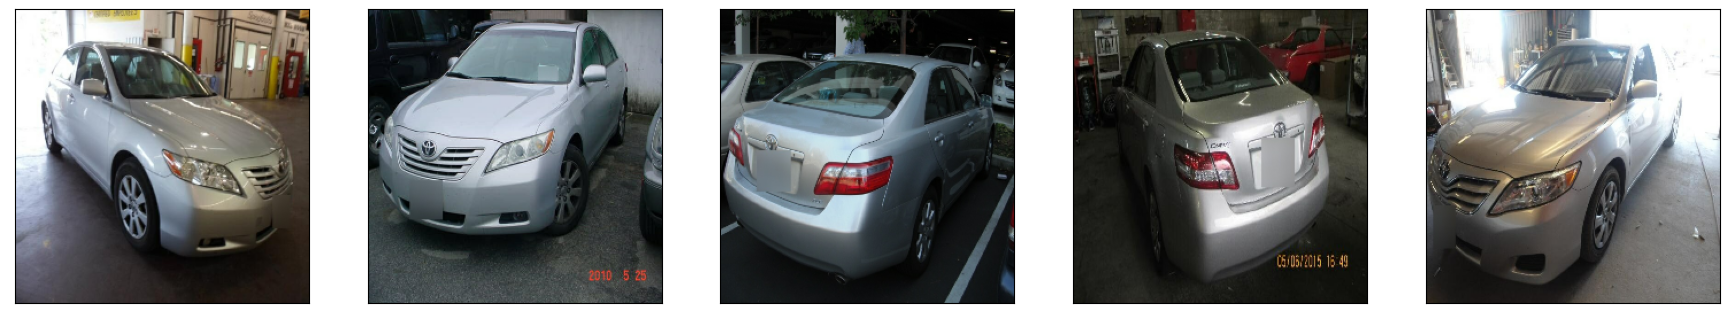

In [14]:
view_image(train_dataset)

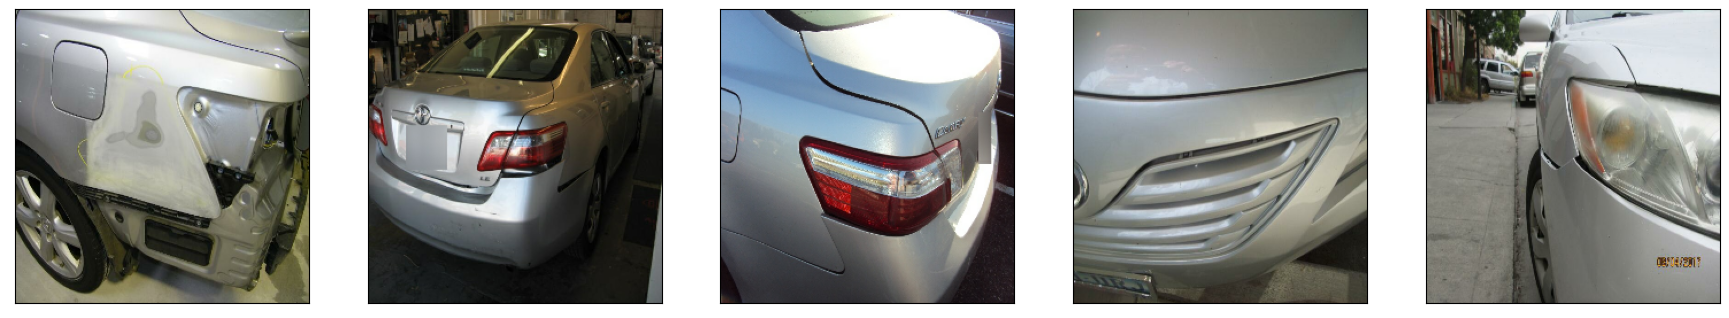

In [15]:
view_image(val_dataset)

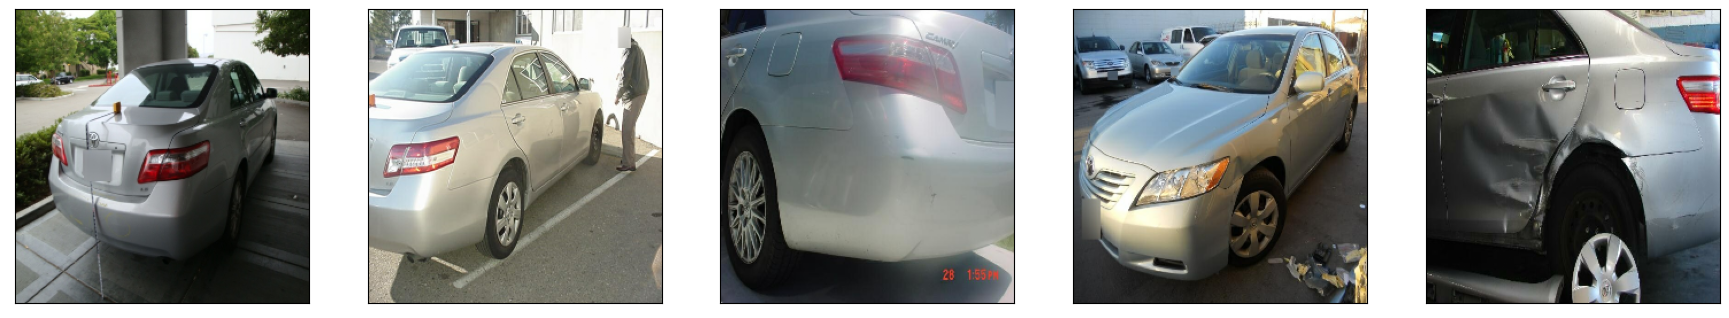

In [16]:
view_image(test_dataset)

## Models

### Encoder model

Input Image ==>> Encoder(Input Image) ==>> Feature Vector

In [17]:
def downsample(filters, kernel_size=(5,5), strides=(2,2), padding='same', use_bn=True, use_act=True, act_type='lrelu', use_bias=False, encdec=None):
    kernel_init = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)
    
    result = tf.keras.Sequential(name=encdec)
    result.add(
        tf.keras.layers.Conv2D(filters, 
                               kernel_size, 
                               strides=strides, 
                               padding=padding,
                               kernel_initializer=kernel_init, 
                               use_bias=use_bias))

    if use_bn:
        result.add(tf.keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1, name=encdec+'_BatchNorm_{}'.format(int(filters))))
        
    if use_act:
        if act_type=='sigmoid':
            result.add(tf.keras.layers.Activation(tf.sigmoid, name=encdec+'_Sigmoid_{}'.format(int(filters))))
        else:
            result.add(tf.keras.layers.LeakyReLU(alpha=0.2, name=encdec+'_LeakyReLU_{}'.format(int(filters))))
    return result

In [18]:
def upsample(filters, kernel_size=(5,5), strides=(2,2), padding='same', use_bn=True, use_act=True, act_type='relu', use_bias=False, encdec=None):
    kernel_init = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)

    result = tf.keras.Sequential(name=encdec)
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, 
                                        kernel_size, 
                                        strides=strides, 
                                        padding=padding,
                                        kernel_initializer=kernel_init, 
                                        use_bias=False))

    if use_bn:
        result.add(tf.keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1, name=encdec+'_BatchNorm_{}'.format(int(filters))))
    
    if use_act:
        if act_type=='tanh':
            result.add(tf.keras.layers.Activation(tf.tanh, name=encdec+'_Tanh_{}'.format(int(filters))))
        else:
            result.add(tf.keras.layers.ReLU(name=encdec+'_ReLU_{}'.format(int(filters))))

    return result

In [19]:
# define the Encoder network
def Encoder(opt, 
            input_layer, 
            n=1):
    
    e = downsample(opt.filters, use_bn=False, encdec='Encoder-{}_1'.format(n))(input_layer)  # (batch_size, 128, 128, 64)
    e = downsample(opt.filters*2, encdec='Encoder-{}_2'.format(n))(e)  # (batch_size, 64, 64, 128)
    e = downsample(opt.filters*4, encdec='Encoder-{}_3'.format(n))(e)   # (batch_size, 32, 32, 256)
    e = downsample(opt.filters*8, encdec='Encoder-{}_4'.format(n))(e)   # (batch_size, 16, 16, 512)
    e = downsample(opt.filters*8, encdec='Encoder-{}_5'.format(n))(e)   # (batch_size, 8, 8, 512)
    e = downsample(opt.filters*8, encdec='Encoder-{}_6'.format(n))(e)   # (batch_size, 4, 4, 512)
    e = downsample(opt.latent_dim, kernel_size=(4,4), strides=(1,1), padding='valid', use_bn=False, use_act=False, encdec='Encoder-{}_7'.format(n))(e)   # (batch_size, 1, 1, 512)

    return e

### Decoder Model
Feature Vector ==>> Decoder(Feature Vector) ==>> Generated Image

In [20]:
# define the Encoder network
def Decoder(opt, 
            input_layer
           ):
    
    d = upsample(opt.filters*8, kernel_size=(4,4), strides=(1, 1), padding='valid', encdec='Decoder_1')(input_layer) # (batch_size, 4, 4, 512)
    d = upsample(opt.filters*8, encdec='Decoder_2')(d)   # (batch_size, 8, 8, 512)
    d = upsample(opt.filters*8, encdec='Decoder_3')(d)   # (batch_size, 16, 16, 512)
    d = upsample(opt.filters*4, encdec='Decoder_4')(d)   # (batch_size, 32, 32, 256)
    d = upsample(opt.filters*2, encdec='Decoder_5')(d)   # (batch_size, 64, 64, 128)
    d = upsample(opt.filters, encdec='Decoder_6')(d)   # (batch_size, 128, 128, 64)
    d = upsample(opt.num_channels, kernel_size=(4,4), use_bn=False, act_type='tanh', encdec='Decoder_7')(d)   # (batch_size, 256, 256, 3)
        
    return d

### Generator

In [21]:
def Generator(opt):
    x = tf.keras.layers.Input(shape=opt.image_shape, name='input_image')
    
    # Generator Encoder(1) - Input(X) ==>> G_Encode(X) ==>> Latent_space(Z)
    z = Encoder(opt, x)
    # Generator Decoder - Latent_space(Z) ==>> G_Decoder(Z) ==>> Fake Image(X_hat)
    x_hat = Decoder(opt, z)
    # # Generator Encoder(1) - Fake Image(X_hat) ==>> G_Encoder(X_hat) ==>> Latent_space(Z_o)
    z_o = Encoder(opt, x_hat, n=2)
    
    return tf.keras.models.Model(inputs=x, outputs=[z, x_hat, z_o], name='Generator')

In [22]:
NetG = Generator(opt)
# # summarize the model
NetG.summary(line_length = 150)

Model: "Generator"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                                      Output Shape                                                Param #                
 input_image (InputLayer)                                          [(None, 256, 256, 3)]                                       0                      
                                                                                                                                                      
 Encoder-1_1 (Sequential)                                          (None, 128, 128, 64)                                        4800                   
                                                                                                                                                      
 Encoder-1_2 (Sequential)                                          (None, 6

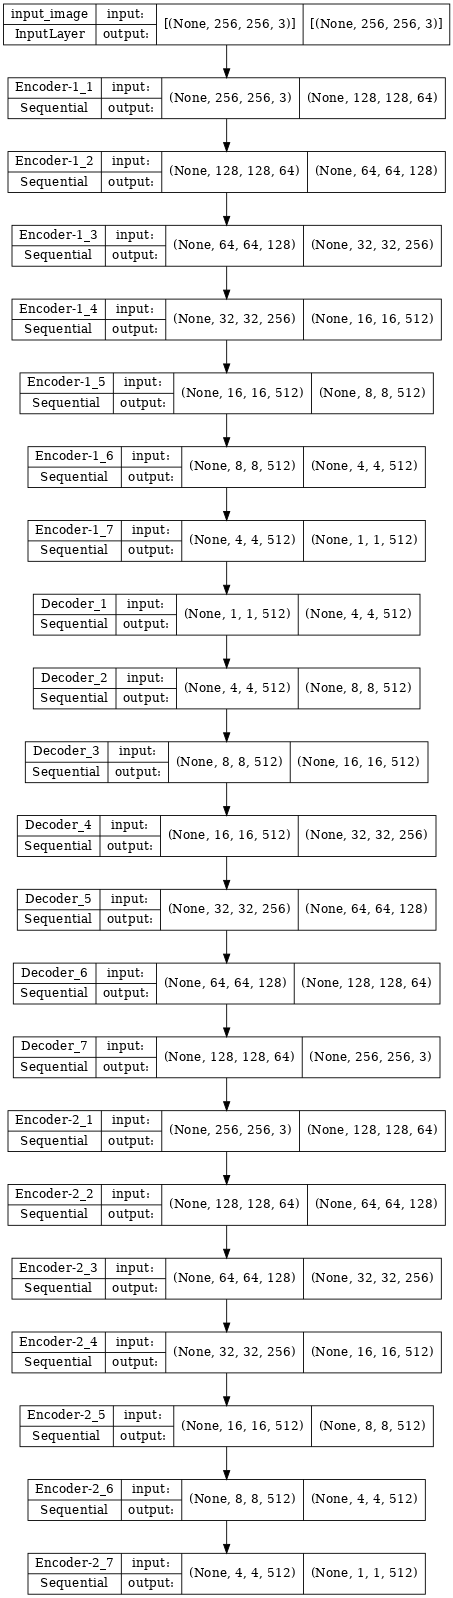

In [23]:
tf.keras.utils.plot_model(NetG, show_shapes=True, dpi=64, to_file='Generator_model.png',)

### Discriminator

In [24]:
def Discriminator(opt):
    
    # Source image input
    x = tf.keras.layers.Input(shape=opt.image_shape, name='input_image')
    
    # Encoder output
    d_0 = tf.keras.layers.GaussianNoise(0.1)(x, training=True)
    d_1 = downsample(opt.filters, use_bn=False, encdec='Discriminator_encoder_1')(d_0)  # (batch_size, 128, 128, 64)
    d_2 = downsample(opt.filters*2, encdec='Discriminator_encoder_2')(d_1)  # (batch_size, 64, 64, 128)
    d_3 = downsample(opt.filters*4, encdec='Discriminator_encoder_3')(d_2)   # (batch_size, 32, 32, 256)
    d_4 = downsample(opt.filters*8, encdec='Discriminator_encoder_4')(d_3)   # (batch_size, 16, 16, 512)
    d_5 = downsample(opt.filters*8, encdec='Discriminator_encoder_5')(d_4)   # (batch_size, 8, 8, 512)
    d_last_feature = downsample(opt.filters*8, encdec='Discriminator_last_feature')(d_5)   # (batch_size, 4, 4, 512)
    
    d_class = downsample(1, kernel_size=(4,4), strides=(1,1), padding='valid', act_type='sigmoid', use_bn=False, encdec='Discriminator_class')(d_last_feature)   # (batch_size, 1, 1, 1)

    return tf.keras.models.Model(inputs=x, outputs=[d_last_feature, d_class], name='Discriminator')
    

In [25]:
# create the model
NetD = Discriminator(opt)
# summarize the model
NetD.summary(line_length = 150)

Model: "Discriminator"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                                      Output Shape                                                Param #                
 input_image (InputLayer)                                          [(None, 256, 256, 3)]                                       0                      
                                                                                                                                                      
 gaussian_noise (GaussianNoise)                                    (None, 256, 256, 3)                                         0                      
                                                                                                                                                      
 Discriminator_encoder_1 (Sequential)                              (Non

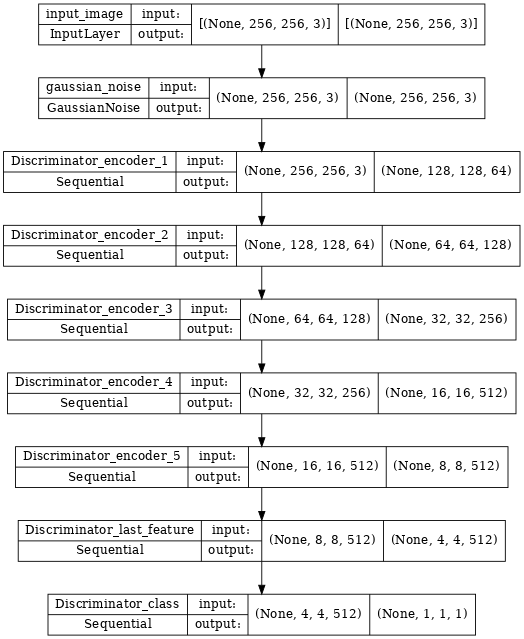

In [26]:
tf.keras.utils.plot_model(NetD, show_shapes=True, show_layer_activations=True, dpi=64, to_file='Discriminator_model.png',)

In [28]:
class GANomaly_Trainer(tf.keras.Model):
    def __init__(self, 
                 opt,
                 Generator,
                 Discriminator):
        
        super(GANomaly_Trainer, self).__init__()
        self.opt = opt
        self.G = Generator(self.opt)
        self.D = Discriminator(self.opt)
        
    def call(self, inputs, training=None, mask=None):
        return (
            self.G(inputs),
            self.D(inputs),
        )

    
    def compile(self, 
                D_optimizer, 
                G_optimizer,
                G_loss_fn,
                D_loss_fn,
               ):
        super(GANomaly_Trainer, self).compile()
        self.D_optimizer = D_optimizer
        self.G_optimizer = G_optimizer
        
        self.G_loss_fn = G_loss_fn
        self.D_loss_fn = D_loss_fn
        
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
        
    # @tf.function
    def train_step(self, batch_data):
        self.x = batch_data
        batch_size = tf.shape(self.x)[0]
        
        self.z, self.x_hat, self.z_o = self.G(self.x)
        
        combined_images = tf.concat([self.x_hat, self.x], axis=0)
        
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        
        # For GANomaly, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass the real image (x) through the generator's encoder and get the latentvector (z)
        # 2. Pass the latent vector (z) through the generator's decoder and get fakeimage (x_hat)
        # 3. Pass the fake image (x_hat) through an encoder network to get latentvector (z_o)
        # 4. Pass the real image (x) and generated image (x_hat) to corresponding discriminators
        #    to get classification label (real/fake) and feature vectors (z/z_o).
        # 5. Calculate the generators total loss (adverserial + contextual + encoder)
        # 6. Calculate the discriminators loss (d_real + d_fake) * 0.5
        # 7. Update the weights of the generator
        # 8. Update the weights of the discriminator
        # 9. Return the losses
        
        """ Autograph enabled by tf.function could speedup more than 6x than eager mode.
        """
        
        with tf.GradientTape() as disc_tape:
            predictions = self.D(combined_images)
            self.D_loss = self.D_loss_fn(labels, predictions)
        # Get the gradients for the discriminator
        D_grads = disc_tape.gradient(self.D_loss, self.D.trainable_variables)   
        # Update the weights of the discriminator
        self.D_optimizer.apply_gradients(zip(D_grads, self.D.trainable_variables))
        
        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))    
        
        with tf.GradientTape() as gen_tape:
            self.z, self.x_hat, self.z_o = self.G(self.x)
            predictions = self.D(self.x_hat)
            # predictions = self.D(self.G(self.x)[1])
            self.g_adv, self.g_con, self.g_enc, self.G_loss = self.G_loss_fn(misleading_labels, predictions,
                                                                             self.x, self.x_hat,
                                                                             self.z, self.z_o)
            G_grads = gen_tape.gradient(self.G_loss, self.G.trainable_variables)
            self.G_optimizer.apply_gradients(zip(G_grads, self.G.trainable_variables))
        
        # Update metrics
        self.d_loss_metric.update_state(self.D_loss)
        self.g_loss_metric.update_state(self.G_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
            "g_adv": self.g_adv, 
            "g_con" :self.g_con, 
            "g_enc": self.g_enc,
        }
            
            
#         # with tf.GradientTape(persistent=True) as tape: 
#         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#             # persistent=True means more than one call can be made to the gradient() method on this object.
            
#             # - forward propagating through NetG
#             self.z, self.x_hat, self.z_o = self.G(self.x, training=True)
#             # - forward propagating through NetD
#             self.feat_real, self.pred_real = self.D(self.x, training=True)
#             self.feat_fake, self.pred_fake = self.D(self.x_hat, training=True)
            
#             # Generator and Discriminator losses
#             # g_adv, g_con, g_enc, g_loss
#             self.g_adv, self.g_con, self.g_enc, self.G_loss = self.G_loss_fn(self.feat_real, self.feat_fake,
#                                                                              self.x, self.x_hat,
#                                                                              self.z, self.z_o)
            
#             self.d_real, self.d_fake, self.D_loss = self.D_loss_fn(self.pred_real,
#                                                                    self.pred_fake)
            
            
            
#         # Get the gradients for the generator
#         G_grads = gen_tape.gradient(self.G_loss, self.G.trainable_variables)
#         # Get the gradients for the discriminator
#         D_grads = disc_tape.gradient(self.D_loss, self.D.trainable_variables)
        
#         # Update the weights of the generator
#         self.G_optimizer.apply_gradients(zip(G_grads, self.G.trainable_variables))
#         # Update the weights of the discriminator
#         self.D_optimizer.apply_gradients(zip(D_grads, self.D.trainable_variables))
        
        
#         return {
#             "G_loss": self.G_loss, 
#             "D_loss": self.D_loss,
#             "g_adv": self.g_adv, 
#             "g_con" :self.g_con, 
#             "g_enc": self.g_enc,
#             "d(x)": self.d_real,
#             "d(x_hat)": self.d_fake,
#         }

In [29]:
def build_model(opt=opt, NetG = NetG, NetD = NetD):

    # adversarial loss (use feature matching)
    l_adv = tf.keras.losses.BinaryCrossentropy(name='bce_loss', from_logits=False)
    # contextual loss
    l_con = tf.keras.losses.MeanAbsoluteError(name='l1_loss')
    # encoder loss - latent space
    l_enc = tf.keras.losses.MeanSquaredError(name='l2_loss')
    # discriminator loss
    l_bce = tf.keras.losses.BinaryCrossentropy(name='bce_loss', from_logits=False)

    def g_loss(labels, 
               preds,
               x,
               x_hat,
               z,
               z_o):

        ''' Backpropagating through NetG '''
        g_adv = l_adv(labels, preds) * opt.w_adv
        g_con = l_con(x, x_hat) * opt.w_con
        g_enc = l_enc(z, z_o) * opt.w_enc 

        g_loss = g_adv  + g_con  + g_enc 

        return g_adv, g_con, g_enc, g_loss

    def d_loss(labels,
               preds):
        
        ''' Backpropagating through NetD '''
        d_loss = l_bce(labels, preds)
        
        return d_loss

    # Create GANomaly model
    GANomaly_model = GANomaly_Trainer(opt=opt, Generator = Generator, Discriminator = Discriminator)
    #  compute output shape to fix for save error
    GANomaly_model.compute_output_shape(input_shape=(None, 256, 256, 3))
    # Compile the model
    GANomaly_model.compile(D_optimizer=tf.keras.optimizers.Adam(opt.lr_d, beta_1=opt.beta1, beta_2=opt.beta2),
                           G_optimizer=tf.keras.optimizers.Adam(opt.lr_g, beta_1=opt.beta1, beta_2=opt.beta2),
                           G_loss_fn = g_loss, 
                           D_loss_fn = d_loss)
    
    return GANomaly_model

In [37]:
GANomaly_model = build_model()
GANomaly_model.summary()

Model: "ga_nomaly__trainer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Functional)      [(None, 1, 1, 512),       64842880  
                              (None, 256, 256, 3),               
                              (None, 1, 1, 512)]                 
                                                                 
 Discriminator (Functional)  [(None, 4, 4, 512),       17428672  
                              (None, 1, 1, 1)]                   
                                                                 
Total params: 82,271,556
Trainable params: 82,256,064
Non-trainable params: 15,492
_________________________________________________________________


In [38]:
class GANomaly_Plotter(tf.keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, train_ds, test_ds, num_img=4):
        self.num_img = num_img
        self.train_dataset = train_ds
        self.test_dataset = test_ds

    def on_epoch_end(self, epoch, logs=None):
        fig, ax = plt.subplots(4, 4, figsize=(8, 10))
        
        for i, img_train in enumerate(self.train_dataset.take(self.num_img)):
            [_, x_hat_train, _] = self.model.G(img_train)
            x_hat_train = (x_hat_train[0] * 127.5 + 127.5).numpy().astype(np.uint8)
            x_train = (img_train[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(x_train)
            ax[i, 1].imshow(x_hat_train)
            ax[i, 0].set_title("Input image", fontsize=10)
            ax[i, 1].set_title("Translated image", fontsize=10)
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

        for i, img_test in enumerate(self.test_dataset.take(self.num_img)):
            [_, x_hat_test, _] = self.model.G(img_test)
            x_hat_test = (x_hat_test[0] * 127.5 + 127.5).numpy().astype(np.uint8)
            x_test = (img_test[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 2].imshow(x_test, cmap='gray')
            ax[i, 3].imshow(x_hat_test, cmap='gray')
            ax[0, 2].set_title("Test Input image", fontsize=10)
            ax[0, 3].set_title("Test Translated image", fontsize=10)
            ax[i, 2].axis("off")
            ax[i, 3].axis("off")
            
            # x_hat = tf.keras.preprocessing.image.array_to_img(x_hat)
            fig.savefig(
                "generated_img/generated_img_{epoch:03d}.png".format(i=i, epoch=epoch + 1)
            )
            plt.tight_layout()
            plt.close()


In [ ]:
run_dir = './model_checkpoints'

def train_model(model, max_epochs, initial_epoch=0):
    
    start_time = time.time()
    
    # define callback functions
    plotter = GANomaly_Plotter(train_ds = train_dataset, test_ds = test_dataset)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(save_freq=20, filepath=os.path.join(run_dir, opt.ckpt_dir, 'ganomaly.{epoch:03d}'))
    csv_logger = tf.keras.callbacks.CSVLogger("training.csv", append=True)
    
    # model fit
    model.fit(train_dataset,
              epochs=max_epochs,
              initial_epoch = initial_epoch,
              steps_per_epoch = len(train_undamaged_toyota) // opt.batch_size,
              callbacks=[plotter, model_checkpoint_callback, csv_logger])
    
    elapsed_time = time.time() - start_time
    time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    print("Elapsed time: {}".format(elapsed_time))

In [ ]:
train_model(GANomaly_model, max_epochs=20)

## Train per step

### Define Loss functions

In [27]:
# Adapted from https://www.kaggle.com/code/jadeblue/dcgans-and-techniques-to-optimize-them/notebook

# randomly flip some labels
def noisy_labels(y, p_flip):
    # determine the number of labels to flip
    n_select = int(p_flip * int(y.shape[0]))
    # choose labels to flip
    flip_ix = np.random.choice([i for i in range(int(y.shape[0]))], size=n_select)
    
    op_list = []
    # invert the labels in place
    #y_np[flip_ix] = 1 - y_np[flip_ix]
    
    for i in range(int(y.shape[0])):
        if i in flip_ix:
            op_list.append(tf.subtract(1.0, y[i]))    
        else:
            op_list.append(y[i])
    
    outputs = tf.stack(op_list)
    return outputs

''' Label smoothing -- technique from GAN hacks, instead of assigning 1/0 as class 
    labels, we assign a random integer in range [0.9, 1.0] for positive class
    and [0.0, 0.1] for negative class '''

def smooth_positive_labels(y):
    return tf.abs(y - np.random.random(y.shape) * 0.1)

def smooth_negative_labels(y):
    return np.random.random(y.shape) * 0.1 + y

In [28]:
bce_loss = tf.keras.losses.BinaryCrossentropy(name='bce_loss', from_logits=False)
l2_loss = tf.keras.losses.MeanSquaredError()
l1_loss = tf.keras.losses.MeanAbsoluteError()

def generator_loss(
    feat_real, feat_fake,
    pred_fake,
    x, x_hat,
    z, z_o):
    
    ''' Backpropagating through NetG '''

    g_adv = (l2_loss(feat_real, feat_fake) + bce_loss(tf.ones_like(pred_fake), pred_fake)) * opt.w_adv
    g_con = l1_loss(x, x_hat) * opt.w_con
    g_enc = l2_loss(z, z_o) * opt.w_enc 


    g_loss = g_adv + g_con + g_enc

    return g_adv, g_con, g_enc, g_loss

def discriminator_loss(pred_real,
                       pred_fake):

    ''' Backpropagating through NetD '''
    
    real_noisy = noisy_labels(tf.ones_like(pred_real), 0.05)  # add noise to real labels with prob of 0.05
    fake_noisy = noisy_labels(tf.zeros_like(pred_fake), 0.05) # add noise to fake labels with prob of 0.05
    
    real_smooth = smooth_positive_labels(real_noisy)  # random number between 0.9 and 1 for real labels
    fake_smooth = smooth_negative_labels(fake_noisy) # random number between 0 and 0.1 for fake labels
    
    d_real = bce_loss(real_smooth, pred_real) 
    d_fake = bce_loss(fake_smooth, pred_fake)  

    d_loss = d_real + d_fake

    return d_real, d_fake, d_loss

### Optimizers

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(opt.lr_g, beta_1=opt.beta1, beta_2=opt.beta2)
discriminator_optimizer = tf.keras.optimizers.Adam(opt.lr_d, beta_1=opt.beta1, beta_2=opt.beta2)

### Checkpoint

In [30]:
checkpoint_dir = opt.ckpt_dir
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=NetG,
                                 discriminator=NetD)

### Generate Images

2023-01-09 05:42:30.859126: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


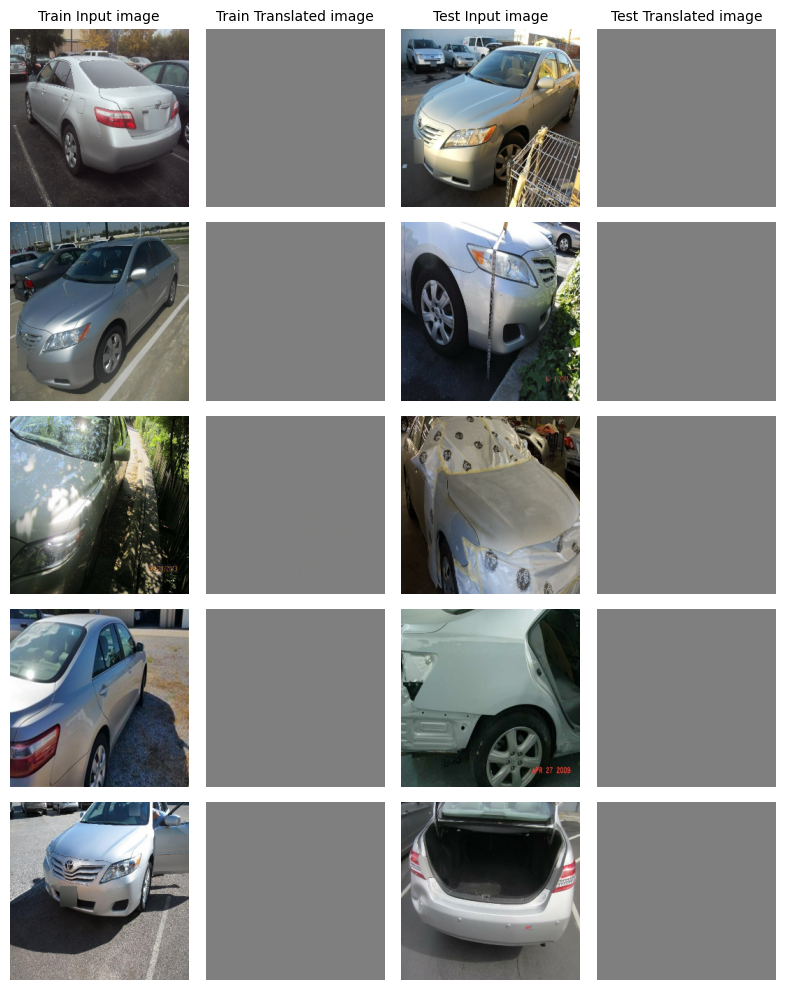

In [31]:
def generate_images(model, train_ds, test_ds, num_img, output):
    fig, ax = plt.subplots(num_img, 4, figsize=(8, 10))
    for i, img_train in enumerate(train_ds.take(num_img)):
        [_, x_hat_train, _] = model(img_train, training=False)
        x_hat_train = (x_hat_train[0] * 127.5 + 127.5).numpy().astype(np.uint8)
        x_train = (img_train[0] * 127.5 + 127.5).numpy().astype(np.uint8)

        ax[i, 0].imshow(x_train, cmap='gray')
        ax[i, 1].imshow(x_hat_train, cmap='gray')
        ax[0, 0].set_title("Train Input image", fontsize=10)
        ax[0, 1].set_title("Train Translated image", fontsize=10)
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
        
    for i, img_test in enumerate(test_ds.take(num_img)):
        [_, x_hat_test, _] = model(img_test, training=False)
        x_hat_test = (x_hat_test[0] * 127.5 + 127.5).numpy().astype(np.uint8)
        x_test = (img_test[0] * 127.5 + 127.5).numpy().astype(np.uint8)

        ax[i, 2].imshow(x_test, cmap='gray')
        ax[i, 3].imshow(x_hat_test, cmap='gray')
        ax[0, 2].set_title("Test Input image", fontsize=10)
        ax[0, 3].set_title("Test Translated image", fontsize=10)
        ax[i, 2].axis("off")
        ax[i, 3].axis("off")
    
    fig.savefig(output)
        
    plt.tight_layout()
    plt.show()
    plt.close()

output_file = "sample_generated_img.png"
generate_images(NetG, train_dataset, val_dataset, 5, output_file)

### Train Step Function

In [32]:
@tf.function
def train_step(x):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        z, x_hat, z_o = NetG(x, training=True)

        feat_real, pred_real = NetD(x, training=True)
        feat_fake, pred_fake  = NetD(x_hat, training=True)

        g_adv, g_con, g_enc, g_loss = generator_loss(feat_real, feat_fake, pred_fake, x, x_hat, z, z_o)
        d_real, d_fake, d_loss = discriminator_loss(pred_real,pred_fake)

    generator_gradients = gen_tape.gradient(g_loss, NetG.trainable_variables)
    discriminator_gradients = disc_tape.gradient(d_loss, NetD.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, NetG.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, NetD.trainable_variables))
        
    return g_loss, d_loss, g_adv, g_con, g_enc, d_real, d_fake

In [33]:
trainlog = pd.DataFrame(columns=['EPOCH', 'Steps', 'G_loss', 'D_loss', 'g_adv', 'g_con', 'g_enc', 'd_X', 'd_X_hat'])

### Fit Function

In [35]:
# Adapted from https://www.tensorflow.org/tutorials/generative/pix2pix
def fit(train_ds, val_ds, epochs):
    start = time.time()
    global_step=0
    for epoch in range(epochs):
        start = time.time()

        G_losses = []
        D_losses = []
        
        step=0
        for image_batch in train_ds:
            global_step+=1
            step+=1

            G_loss, D_loss, g_adv, g_con, g_enc, d_x, d_x_hat = train_step(image_batch)
            trainlog.loc[len(trainlog)] = [epoch+1, global_step, G_loss.numpy(), D_loss.numpy(), g_adv.numpy(), g_con.numpy(), g_enc.numpy(), d_x.numpy(), d_x_hat.numpy()]
            
            G_losses.append(G_loss)
            D_losses.append(D_loss)

            print ("\033[1mGlobal Steps\033[0m: {}, \033[1mEpoch Steps\033[0m: {},\
                   \033[91mG_LOSS\033[0m: {:.4f}, \033[91mD_LOSS\033[0m: {:.4f}, \
                   \033[94mg_adv\033[0m: {:.4f}, \033[94mg_con\033[0m: {:.4f}, \033[94mg_enc\033[0m: {:.4f}, \
                   \033[92md_real\033[0m: {:.4f}, \033[92md_fake\033[0m: {:.4f}"
                   .format(global_step, 
                            step, 
                            G_loss.numpy(), 
                            D_loss.numpy(),
                            g_adv.numpy(), 
                            g_con.numpy(),
                            g_enc.numpy(),
                            d_x.numpy(), 
                            d_x_hat.numpy()
                           ),
                   end='', flush=True)
            print('\r', end='')
                
       
        display.clear_output(wait=True)
        print (f"Epoch : {epoch+1}, \t Time : {time.time()-start:.2f} sec/n, \t Gen Loss mean : {np.mean(G_losses):.4f}, std: {np.std(G_losses):.4f}; \t Dis Loss mean : {np.mean(D_losses):.4f}, std: {np.std(D_losses):.4f};")
         # Generate training and validation images
        output_file = f"GANomaly_modified_gen_imgs/generated_imgs_{epoch+1}.png"
        generate_images(NetG, train_ds, val_ds, 5, output_file)
        
        # plot the losses
        plt.figure(figsize=(10,4))
        plt.title("Generator and Discriminator Loss - EPOCH {}".format(epoch+1))
        plt.plot(G_losses,label="G")
        plt.plot(D_losses,label="D")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True, linestyle='--')
        ymax = plt.ylim()[1]
        plt.show()
        
        trainlog.plot(x="Steps", y=["D_loss", "G_loss"], figsize=(10, 4), ylim=(0,30))
        plt.title("All Time Loss")
        plt.ylabel("Loss")
        plt.xlabel("Iterations")
        G_loss_smoothed = gaussian_filter1d(trainlog.G_loss, sigma=25)
        plt.plot(trainlog.Steps, G_loss_smoothed)
        plt.grid(True, linestyle='--')
        plt.show()
         
        if (epoch+1) % 300 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            

Epoch : 300, 	 Time : 278.66 sec/n, 	 Gen Loss mean : 7.6090, std: 0.3898; 	 Dis Loss mean : 0.6247, std: 0.0149;


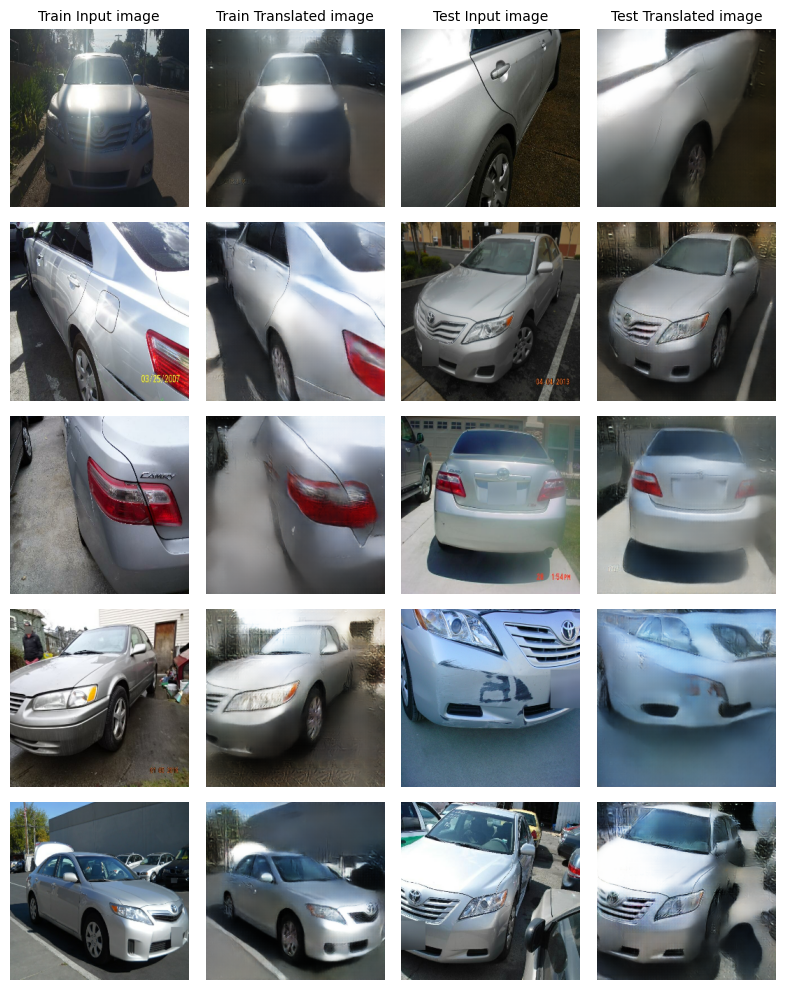

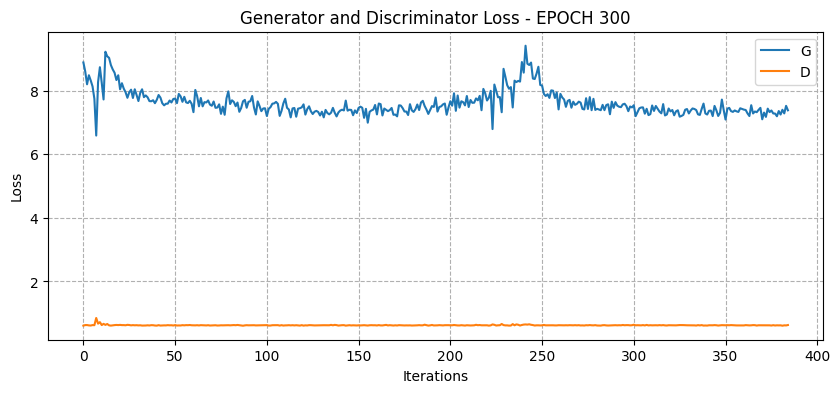

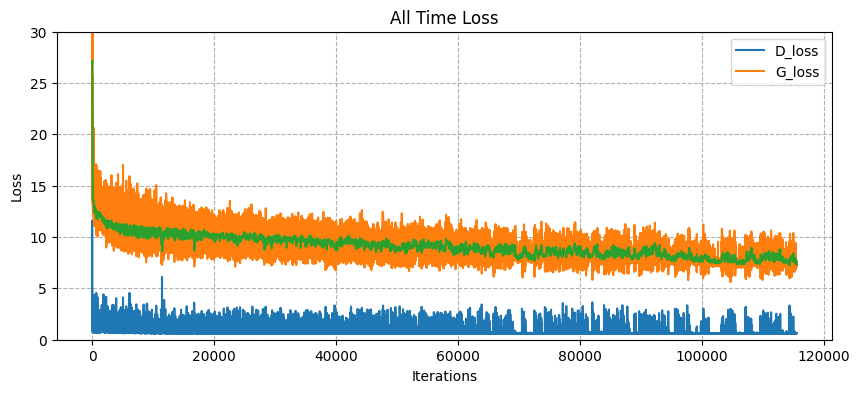

In [36]:
fit(train_dataset, val_dataset, epochs=300)

## Trainlog

In [45]:
trainlog.to_csv('trainlog_GANomaly_modified.csv', index=False)

In [34]:
trainlog = pd.read_csv('trainlog_GANomaly_modified.csv')

In [35]:
trainlog

EPOCH     Steps     G_loss     D_loss      g_adv      g_con     g_enc  \
0         1.0       1.0  28.815697   1.771188   1.237352  24.190207  3.388139   
1         1.0       2.0  65.747192   8.565987  38.929825  23.731226  3.086146   
2         1.0       3.0  27.027199  11.595357   0.744349  23.509615  2.773235   
3         1.0       4.0  58.063213   4.497752  32.530716  23.492653  2.039845   
4         1.0       5.0  37.508205   2.865129  11.371058  24.144136  1.993010   
...       ...       ...        ...        ...        ...        ...       ...   
115495  300.0  115496.0   7.250487   0.621955   2.350034   4.886315  0.014138   
115496  300.0  115497.0   7.399929   0.610145   2.347488   5.037575  0.014866   
115497  300.0  115498.0   7.285731   0.621453   2.393516   4.877476  0.014739   
115498  300.0  115499.0   7.523402   0.618716   2.429710   5.078750  0.014942   
115499  300.0  115500.0   7.383132   0.630825   2.404832   4.963671  0.014630   

             d_X   d_X_hat  
0       0.637297  1.133891  
1       5.176443  3.389544  
2       2.288192  9.307165  
3       1.575333  2.922419  
4       2.257059  0.608070  
...          ...       ...  
115495  0.316272  0.305683  
115496  0.305389  0.304757  
115497  0.316126  0.305327  
115498  0.308926  0.309789  
115499  0.320222  0.310603  

[115500 rows x 9 columns]

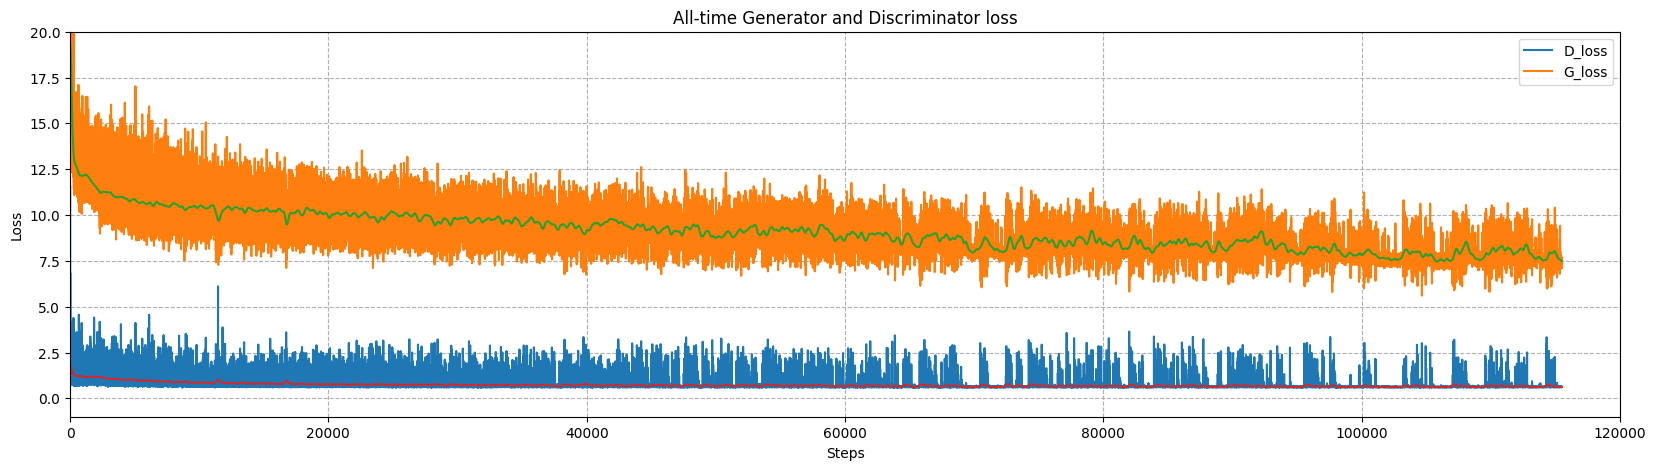

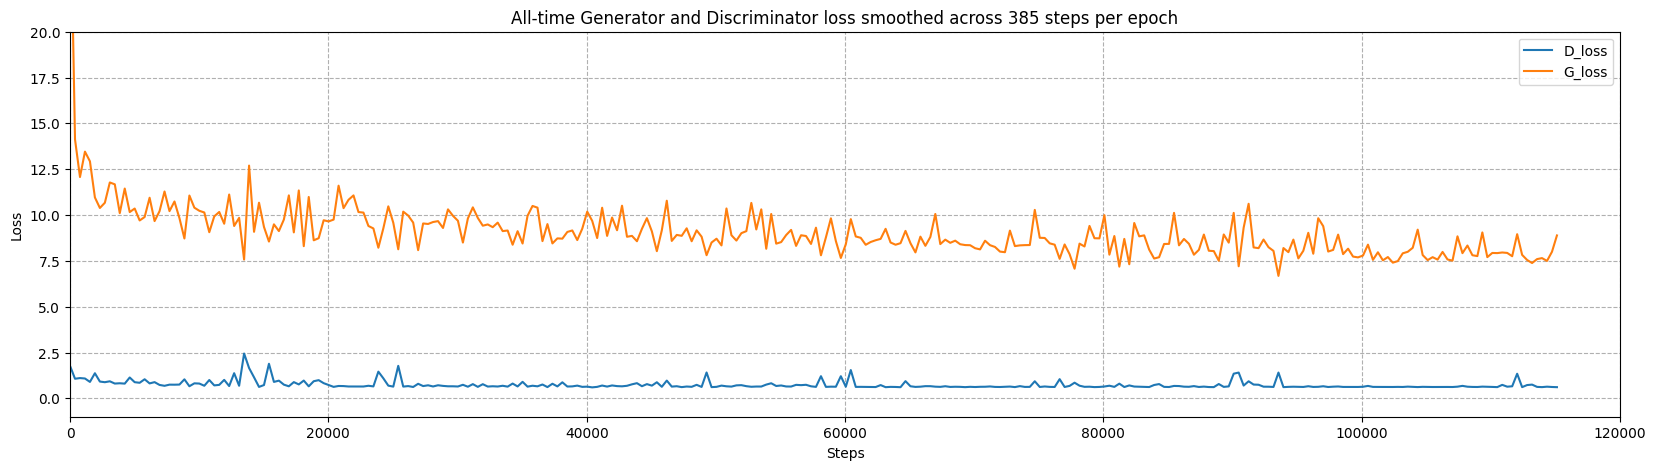

In [36]:
# Plot Discriminator and Generator Losses
trainlog.plot(x="Steps", y=["D_loss", "G_loss"], figsize=(20, 5), ylim=(-1,20))
G_loss_smoothed = gaussian_filter1d(trainlog.G_loss, sigma=100)
D_loss_smoothed = gaussian_filter1d(trainlog.D_loss, sigma=100)
plt.plot(trainlog.Steps, G_loss_smoothed)
plt.plot(trainlog.Steps, D_loss_smoothed)
plt.grid(True, linestyle='--')
plt.ylabel("Loss")
plt.xlim(0, 120000)
plt.title("All-time Generator and Discriminator loss")
plt.show()

plt.figure(figsize=(20,5))
Disc_Loss = trainlog.D_loss[::385]
Gen_Loss = trainlog.G_loss[::385]
steps = trainlog.Steps[::385]
plt.plot(steps, Disc_Loss, label='D_loss')
plt.plot(steps, Gen_Loss, label='G_loss')
plt.grid(True, linestyle='--')
plt.legend(loc="upper right")
plt.ylim(-1, 20)
plt.xlim(0, 120000)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("All-time Generator and Discriminator loss smoothed across 385 steps per epoch")
plt.show()

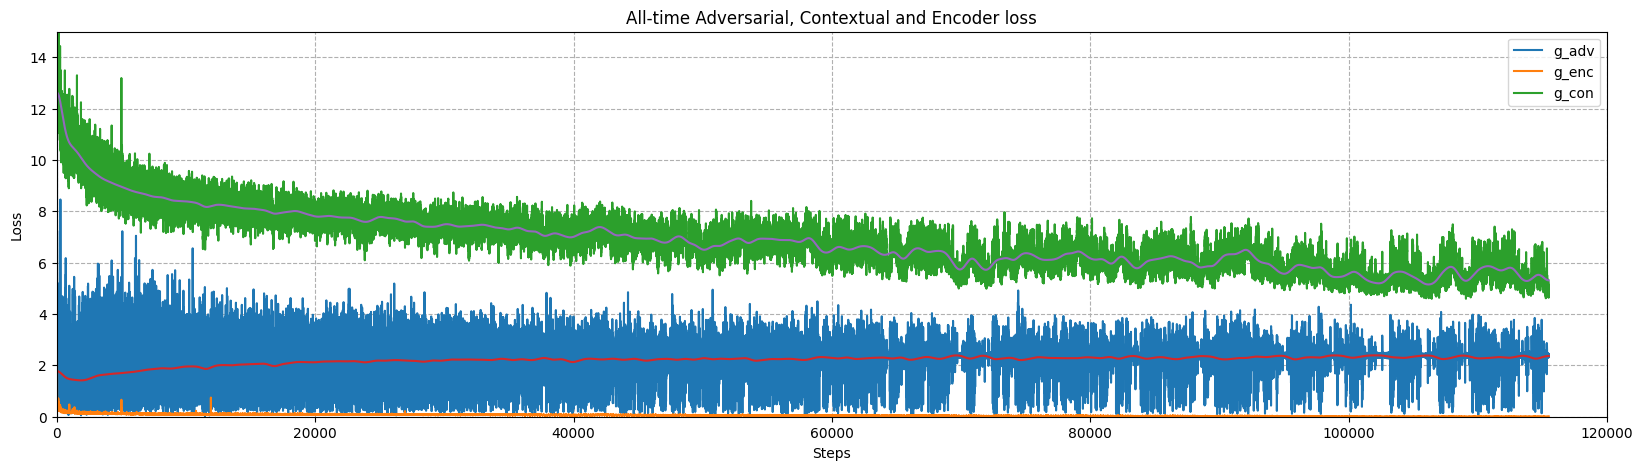

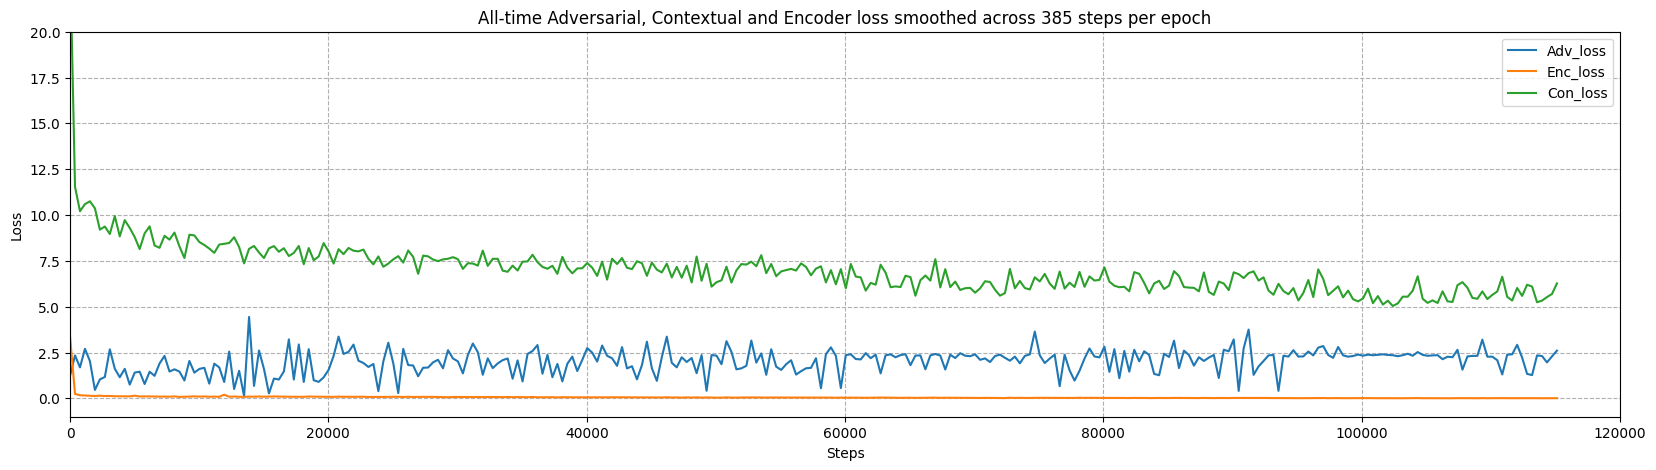

In [40]:
# plot Adversarial, Contextual and Encoder Losses
trainlog.plot(x="Steps", y=["g_adv", "g_enc", "g_con"], figsize=(20, 5), ylim=(0,15))
g_adv_smoothed = gaussian_filter1d(trainlog.g_adv, sigma=385)
g_con_smoothed = gaussian_filter1d(trainlog.g_con, sigma=385)
plt.plot(trainlog.Steps, g_adv_smoothed)
plt.plot(trainlog.Steps, g_con_smoothed)
plt.grid(True, linestyle='--')
plt.ylabel("Loss")
plt.xlim(0, 120000)
plt.title("All-time Adversarial, Contextual and Encoder loss")
plt.show()

plt.figure(figsize=(20,5))
Adv_loss = trainlog.g_adv[::385]
Enc_loss = trainlog.g_enc[::385]
Con_loss = trainlog.g_con[::385]
steps = trainlog.Steps[::385]
plt.plot(steps, Adv_loss, label='Adv_loss')
plt.plot(steps, Enc_loss, label='Enc_loss')
plt.plot(steps, Con_loss, label='Con_loss')
plt.grid(True, linestyle='--')
plt.legend(loc="upper right")
plt.ylim(-1, 20)
plt.xlim(0, 120000)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("All-time Adversarial, Contextual and Encoder loss smoothed across 385 steps per epoch")
plt.show()

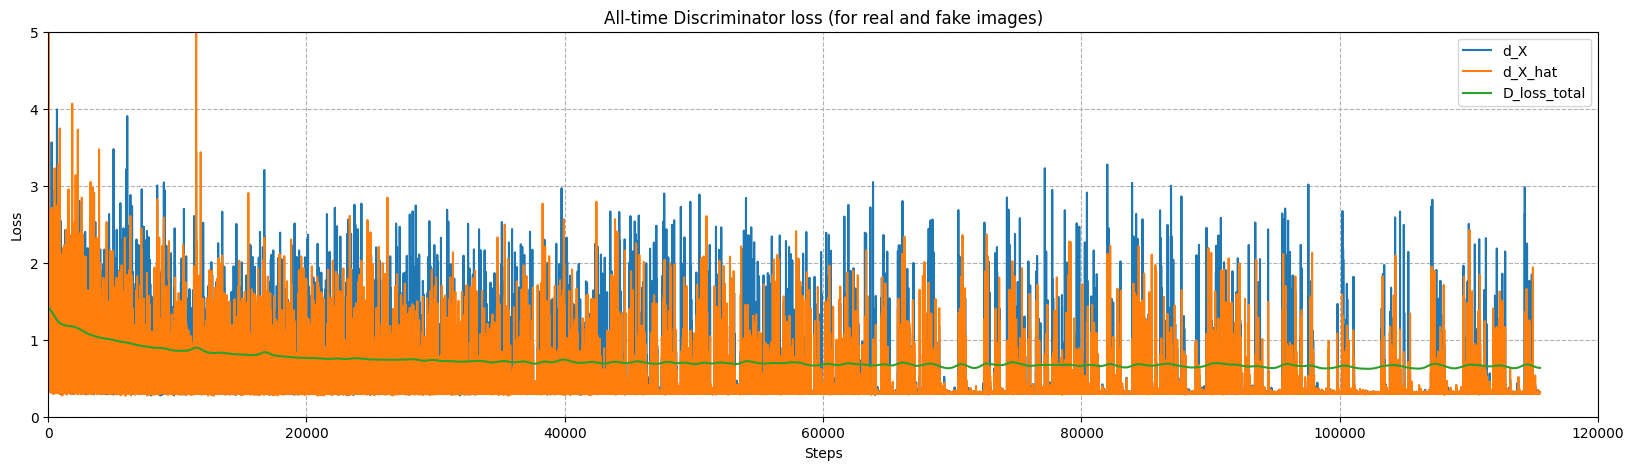

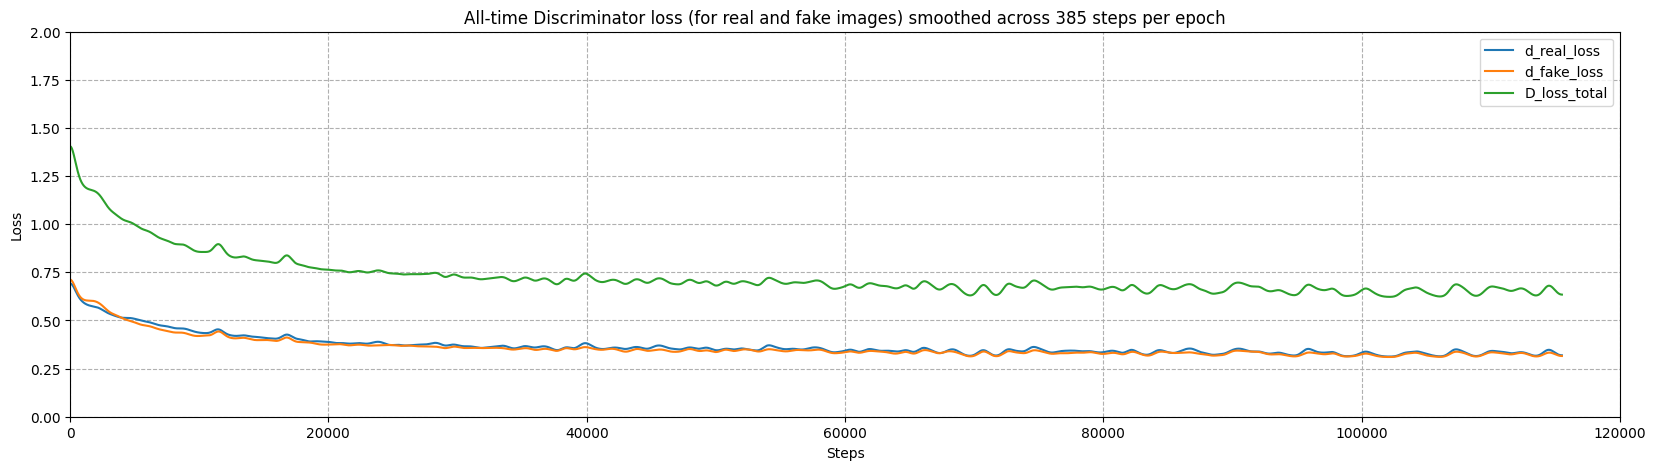

In [41]:
# plot Discriminator Losses
trainlog.plot(x="Steps", y=["d_X", "d_X_hat"], figsize=(20, 5))
D_loss_smoothed = gaussian_filter1d(trainlog.D_loss, sigma=385)
plt.plot(trainlog.Steps, D_loss_smoothed, label='D_loss_total')
plt.grid(True, linestyle='--')
plt.legend(loc="upper right")
plt.ylim(0, 5)
plt.xlim(0, 120000)
plt.ylabel("Loss")
plt.title("All-time Discriminator loss (for real and fake images)")
plt.show()


plt.figure(figsize=(20,5))
d_x_smoothed = gaussian_filter1d(trainlog.d_X, sigma=385)
d_x_hat_smoothed = gaussian_filter1d(trainlog.d_X_hat, sigma=385)
D_loss_smoothed = gaussian_filter1d(trainlog.D_loss, sigma=385)
plt.plot(trainlog.Steps, d_x_smoothed, label='d_real_loss')
plt.plot(trainlog.Steps, d_x_hat_smoothed, label='d_fake_loss')
plt.plot(trainlog.Steps, D_loss_smoothed, label='D_loss_total')
plt.legend(loc="upper right")
plt.xlim(0, 120000)
plt.grid(True, linestyle='--')
plt.ylim(0,2)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("All-time Discriminator loss (for real and fake images) smoothed across 385 steps per epoch")
plt.show()

## FID Score

In [42]:
ls {checkpoint_dir}

checkpoint  ckpt-1.data-00000-of-00001  ckpt-1.index


In [43]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [44]:
# The following FID calculation code has been adapted from Machine learning mastery
# https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/

# Inceptionv3 model for FID calculation
from tensorflow.keras.applications.inception_v3 import InceptionV3
INCEPTION_SHAPE = (299, 299, 3)

inception = InceptionV3(include_top=False, pooling='avg', input_shape=INCEPTION_SHAPE)

def scale_images(images, new_shape):
    """
    Scales images into new shape by interpolation since inception model requires that
    :param images: List of images
    :param new_shape: The transformed shape
    :return: Transformed images
    """

    images_list = list()

    for image in images:
        new_image = resize(image, new_shape)
        images_list.append(new_image)
    
    return np.asarray(images_list)


def calculate_fid(model, images1, images2):
    """

    Calculates the FID with the inception last layer activations
    :param model: THe model (eg: inception)
    :param images1: List of images grouo 1
    :param images1: List of images grouo 2
    :return: FID score
    """
    
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Equation for FID score calculation
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)  

    return fid

In [45]:
from tensorflow.python.ops.numpy_ops import np_config
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.linalg import sqrtm
np_config.enable_numpy_behavior()
FID_BATCH_SIZE = 10

from skimage.transform import resize
fid_train_total = []
for i, x in enumerate(train_dataset.take(50)):
    [_, x_hat, _] = NetG(x, training=False)
    x = scale_images(x.astype('float32'), INCEPTION_SHAPE)
    x_hat = scale_images(x_hat.astype('float32'), INCEPTION_SHAPE)
    x = preprocess_input(x)
    x_hat = preprocess_input(x_hat)
    cur_fid_score = calculate_fid(inception, x, x_hat)
    fid_train_total.append(cur_fid_score)
    print(cur_fid_score)

9.103176664784382
9.540666273965076
11.53873008526465
10.609350392059778
9.044200154819292
8.134915393755833
9.310613384465052
9.974800170543467
8.202578152828547
11.615621772476407
8.496376510511029
7.654819155055213
8.480762358564583
8.226292815914347
8.322412874780337
12.061709720203508
7.907091934796749
7.5457945830599735
9.585259914959734
9.667745270135407
9.386247920417597
7.517083841451706
9.029683143561186
8.271836696456038
9.882910926837834
7.175059237094039
8.676857962350017
9.023507284122593
8.850124645761333
10.583574072966728
9.71076378738328
8.017392839288487
9.46370276045806
9.084655909621938
10.144319724372448
9.264598341860601
8.901498508981872
8.200820963324688
11.164333757104322
9.414583498299885
9.688752220333226
8.63680579216957
9.474212696948204
10.625010402930908
10.627980002711897
9.872656876766253
9.955796687987727
11.007077062397983
8.016066769904159
8.779294700688602


In [46]:
print(f'Mean Fid Score for train dataset: {np.mean(fid_train_total):.4f}')
print(f'Standard Deviation Fid Score for train dataset: {np.std(fid_train_total):.4f}')

Mean Fid Score for train dataset: 9.2694
Standard Deviation Fid Score for train dataset: 1.1215


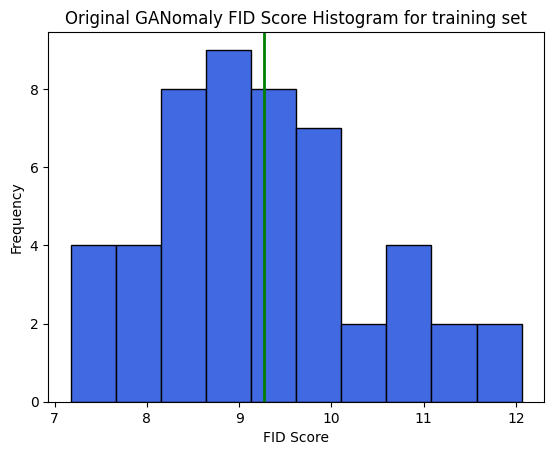

In [47]:
import statistics

plt.hist(fid_train_total, bins=10, color='royalblue', edgecolor='k')

mean = statistics.mean(fid_train_total)
std = statistics.stdev(fid_train_total)

plt.axvline(mean, color='g', lw=2.0)

plt.xlabel("FID Score")
plt.ylabel("Frequency")
plt.title("Original GANomaly FID Score Histogram for training set")
plt.show()

In [48]:
fid_test_total = []
for i, x in enumerate(val_dataset.take(50)):
    [_, x_hat, _] = NetG(x, training=False)
    x = scale_images(x.astype('float32'), INCEPTION_SHAPE)
    x_hat = scale_images(x_hat.astype('float32'), INCEPTION_SHAPE)
    x = preprocess_input(x)
    x_hat = preprocess_input(x_hat)
    cur_fid_score = calculate_fid(inception, x, x_hat)
    fid_test_total.append(cur_fid_score)
    print(cur_fid_score)

38.30548212705491
14.80655826389834
35.33299627777598
24.14188128267589
28.577096448326138
35.11546165335429
22.812589371079163
26.50209025290026
13.558914307063038
10.669075604670603
25.714555113847716
14.09461425197928
19.803185011462872
19.51678519555376
31.121061502918845
24.08349732050919
15.184158761193718
30.493498987999985
13.24044198390968
21.253384963060867
15.220352426193573
20.71096102272648
20.84496935354557
11.055137758181909
18.310727827744227
24.44811910505006
13.93838082781518
13.142715590872694
16.328945351960645
18.30822151484627
22.691130658189774
19.484505018534097
15.67841137488112
48.20652197183652
26.934360623628315
33.752907120617174
14.757583670963948
18.353769873710366
30.466388182164447
16.573156876246625
12.456945475316605
24.888079436199575
23.50609996642911
12.975848009267192
16.524973620170652
14.386848252838732
17.887374407558198
23.926731928338302
24.81650839371355
36.704422258995976


In [49]:
print(f'Mean Fid Score for test dataset: {np.mean(fid_test_total):.4f}')
print(f'Standard Deviation Fid Score for test dataset: {np.std(fid_test_total):.4f}')

Mean Fid Score for test dataset: 21.8322
Standard Deviation Fid Score for test dataset: 8.0764


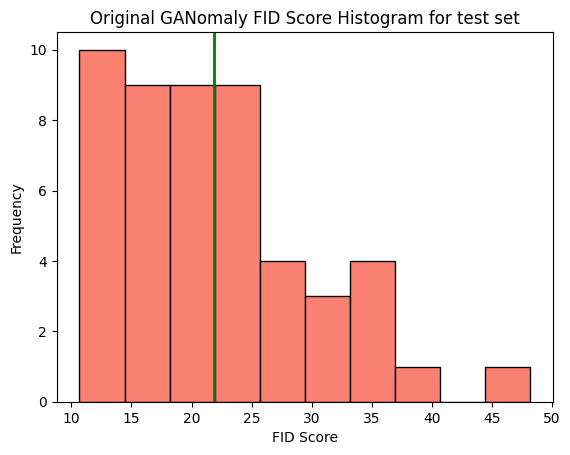

In [50]:
import statistics

plt.hist(fid_test_total, bins=10, color='salmon', edgecolor='k')

mean = statistics.mean(fid_test_total)
std = statistics.stdev(fid_test_total)

plt.axvline(mean, color='g', lw=2.0)

plt.xlabel("FID Score")
plt.ylabel("Frequency")
plt.title("Original GANomaly FID Score Histogram for test set")
plt.show()

In [120]:
ls {checkpoint_dir}

checkpoint  ckpt-1.data-00000-of-00001  ckpt-1.index


In [121]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [122]:
# The following FID calculation code has been adapted from Machine learning mastery
# https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/

# Inceptionv3 model for FID calculation
from tensorflow.keras.applications.inception_v3 import InceptionV3
INCEPTION_SHAPE = (299, 299, 3)

inception = InceptionV3(include_top=False, pooling='avg', input_shape=INCEPTION_SHAPE)

def scale_images(images, new_shape):
    """
    Scales images into new shape by interpolation since inception model requires that
    :param images: List of images
    :param new_shape: The transformed shape
    :return: Transformed images
    """

    images_list = list()

    for image in images:
        new_image = resize(image, new_shape)
        images_list.append(new_image)
    
    return np.asarray(images_list)


def calculate_fid(model, images1, images2):
    """

    Calculates the FID with the inception last layer activations
    :param model: THe model (eg: inception)
    :param images1: List of images grouo 1
    :param images1: List of images grouo 2
    :return: FID score
    """
    
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Equation for FID score calculation
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)  

    return fid

In [123]:
from tensorflow.python.ops.numpy_ops import np_config
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.linalg import sqrtm
np_config.enable_numpy_behavior()

FID_BATCH_SIZE = 10

from skimage.transform import resize
fid_train_total = []
for i, x in enumerate(train_dataset.take(10)):
    [_, x_hat, _] = NetG(x, training=False)
    x = scale_images(x.astype('float32'), INCEPTION_SHAPE)
    x_hat = scale_images(x_hat.astype('float32'), INCEPTION_SHAPE)
    x = preprocess_input(x)
    x_hat = preprocess_input(x_hat)
    cur_fid_score = calculate_fid(inception, x, x_hat)
    fid_train_total.append(cur_fid_score)
    print(cur_fid_score)
     
print(f'Mean Fid Score for train dataset: {np.mean(fid_train_total):.4f}')
print(f'Standard Deviation Fid Score for train dataset: {np.std(fid_train_total):.4f}')

10.366971889767047
9.954447400074354
11.45637620680066
9.614064196679582
8.449322805882073
10.405709042405414
8.10679410151381
9.119484113260373
9.609577065930894
9.30965815258104
Mean Fid Score for train dataset: 9.6392


In [ ]:
import statistics

plt.hist(fid_train_total, bins=50, color='c', edgecolor='k')

mean = statistics.mean(fid_train_total)
std = statistics.stdev(fid_train_total)

plt.axvhline(mean, color='y', linestyle='dashed')
plt.axvhline(std, color='y', linestyle='dashed')

plt.xlabel("FID Score")
plt.ylabel("Frequency")
plt.title("Original GANomaly FID Score Histogram for training set")
plt.show()

In [124]:
fid_test_total = []
for i, x in enumerate(val_dataset.take(10)):
    [_, x_hat, _] = NetG(x, training=False)
    x = scale_images(x.astype('float32'), INCEPTION_SHAPE)
    x_hat = scale_images(x_hat.astype('float32'), INCEPTION_SHAPE)
    x = preprocess_input(x)
    x_hat = preprocess_input(x_hat)
    cur_fid_score = calculate_fid(inception, x, x_hat)
    fid_test_total.append(cur_fid_score)
    print(cur_fid_score)
    
print(f'Mean Fid Score for test dataset: {np.mean(fid_test_total):.4f}')

36.746503461162376
16.935006429263332
13.115390787747547
22.708224136606844
21.881517478457425
30.52771716249822
21.507296963908814
18.853775123234506
21.979533831906007
13.895515056979967
Mean Fid Score for test dataset: 21.8150


## Inference

In [55]:
# Run the trained model on a few examples from the test set
def generate_test_images(model, dataset, num_img):
    fig, ax = plt.subplots(num_img, 2, figsize=(5, num_img * 2 ))
    for i, img in enumerate(dataset.take(num_img)):
        [z, x_hat, z_o] = model(img, training=False)
        x_hat = (x_hat[0] * 127.5 + 127.5).numpy().astype(np.uint8)
        x = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

        ax[i, 0].imshow(x)
        ax[i, 1].imshow(x_hat)
        ax[0, 0].set_title("Input image")
        ax[0, 1].set_title("Translated image")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
        
    # fig.savefig(output)
        
    plt.tight_layout()
    plt.show()
    plt.close()

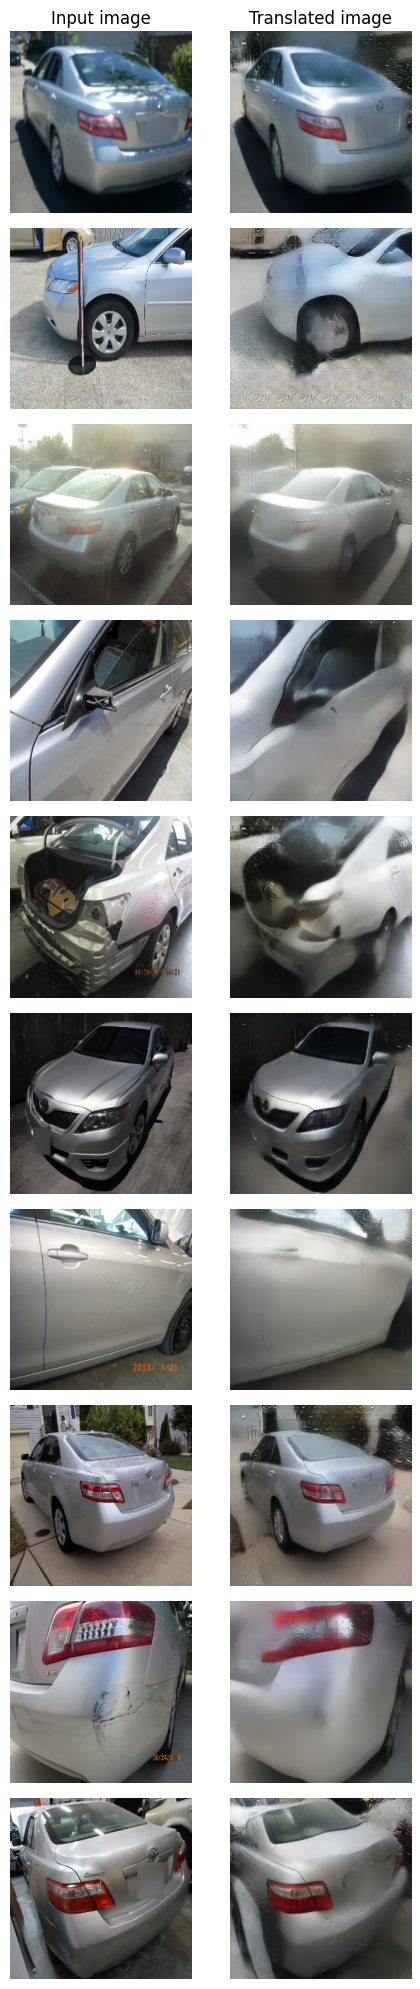

In [65]:
generate_test_images(NetG, val_dataset, 10)

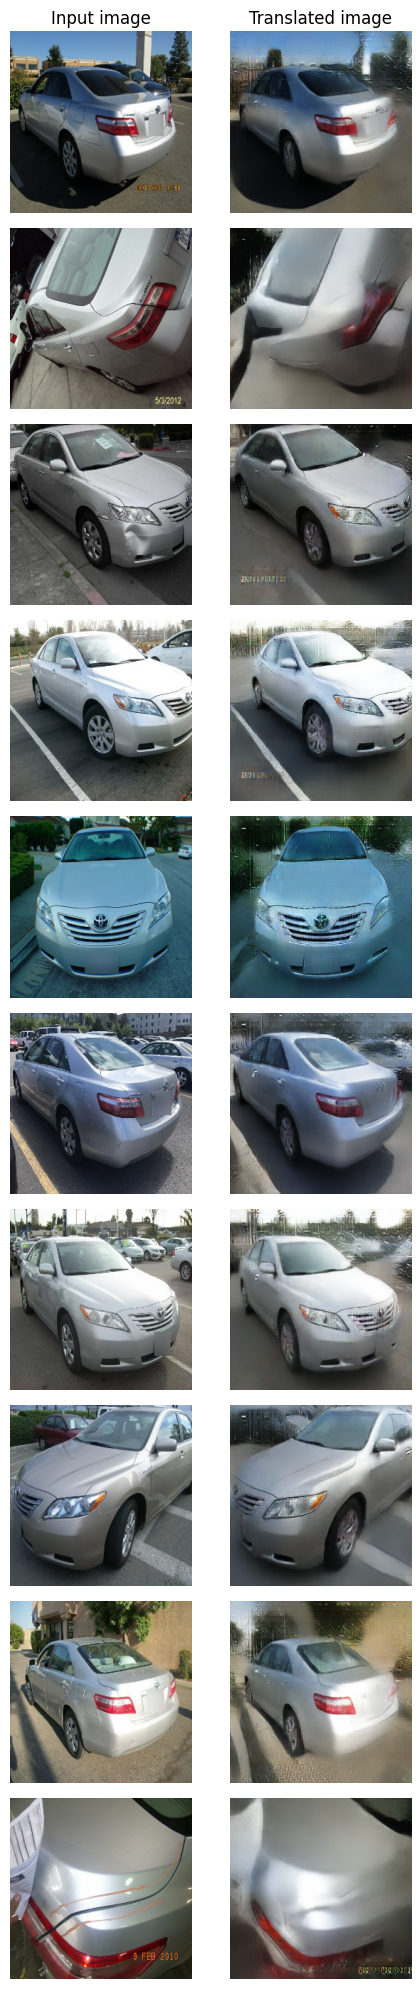

In [54]:
generate_test_images(NetG, train_dataset, 10)